# Import Libraries and Data

In [30]:
# Imports
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics._plot.confusion_matrix import confusion_matrix
from sklearn.metrics import recall_score, make_scorer, roc_curve, roc_auc_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import keras.backend as K

import tensorflow as tf
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger, EarlyStopping
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from imblearn.over_sampling import SMOTE, SMOTENC

In [2]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.9 MB/s eta 0:00:00


In [3]:
import keras_tuner as kt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
BASE_FOLDER="/content/drive/MyDrive/Master-VIU/09MIAR_TFM/Tumor-Educated_Platelets/data/"
PROYECTO="IntVeld2022"
PROYECT_FOLDER = os.path.join(BASE_FOLDER,PROYECTO)

In [6]:
# Read dataFrame
file='DataPatients_train.csv'
df_train = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

file='DataPatients_test.csv'
df_test = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

In [7]:
# Split X and Y
# Choose which label to use for ground truth (in this case class)

columns = df_train.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train[columns[0:-10]]
y_train_c = df_train[columns[-2]]

X_test = df_test[columns[0:-10]]
y_test_c= df_test[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)

y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Train
['Malignant' 'nonMalignant']
[1313  566]
Test
['Malignant' 'nonMalignant']
[313 157]
(1879, 2881) (1879,) (470, 2881) (470,)


# First try of a neural network (manually fine tuned)

In [8]:
# https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
model = Sequential() 
# Input: 2881 neuronas
model.add(Dense(1024, input_shape=(2881,), activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())

# Output: 1 neuron (class Malignant and nonMalignant)
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate = 0.001, beta_1 = 0.5)

model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics = ['accuracy', specificity])


In [ ]:
K.clear_session()

print("[INFO] training the best model...")
# Early Stop
early_stop = EarlyStopping(monitor='val_loss', patience=10)
# Unless you are using ModelCheckpoint callback with save_best_only parameter, 
# model.fit() returns not the best model encountered during the training 
# (i.e. the one with the lowest validation loss or with highest validation accuracy), 
# but rather the model whatever it happens to be at the last epoch 
# (which cannot be counted on to have lowest loss or highest accuracy).
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
# Calculate the weights for each class so that we can balance the data
# https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_s))

H = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, checkpointer], class_weight=class_weights)

[INFO] training the best model...
Epoch 1/100
47/47 [==============================] - 3s 14ms/step - loss: 0.7724 - accuracy: 0.6108 - specificity: 0.6531 - val_loss: 1.7411 - val_accuracy: 0.6596 - val_specificity: 0.0052
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.7550 - accuracy: 0.6401 - specificity: 0.6662 - val_loss: 0.6935 - val_accuracy: 0.6809 - val_specificity: 0.0803
Epoch 3/100
47/47 [==============================] - 0s 9ms/step - loss: 0.6799 - accuracy: 0.6627 - specificity: 0.6812 - val_loss: 0.6709 - val_accuracy: 0.6888 - val_specificity: 0.1507
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6278 - accuracy: 0.6886 - specificity: 0.6922 - val_loss: 0.5448 - val_accuracy: 0.7021 - val_specificity: 0.2039
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 0.6097 - accuracy: 0.6866 - specificity: 0.7217 - val_loss: 0.5554 - val_accuracy: 0.7101 - val_specificity: 0.7555
Epoch 6/100
47/47 

[INFO] evaluating best model...
15/15 [==============================] - 0s 2ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.68      0.52      0.58       157
           1       0.78      0.88      0.83       313

    accuracy                           0.76       470
   macro avg       0.73      0.70      0.71       470
weighted avg       0.75      0.76      0.75       470

[[ 81  76]
 [ 39 274]]


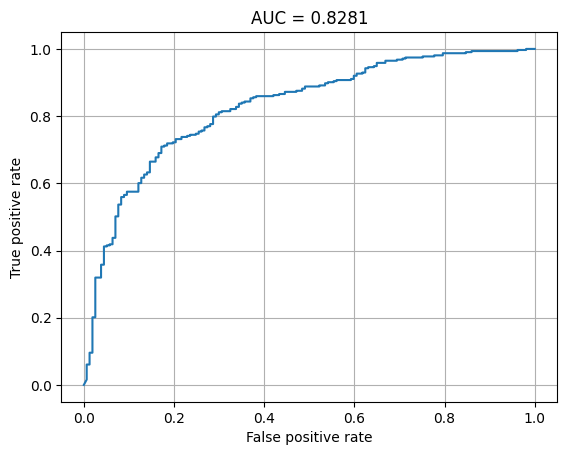

In [ ]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción
model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# acc = (tp + tn)/(tp + tn + fp + fn)
# spe = (tn)/(tn+fp)
# sens = (tp)/(tp+fn)
# print(f"Accuracy: {acc*100:.2f}% \nSpecificity: {spe*100:.2f}% \nSensitivity: {sens*100:.2f}%")

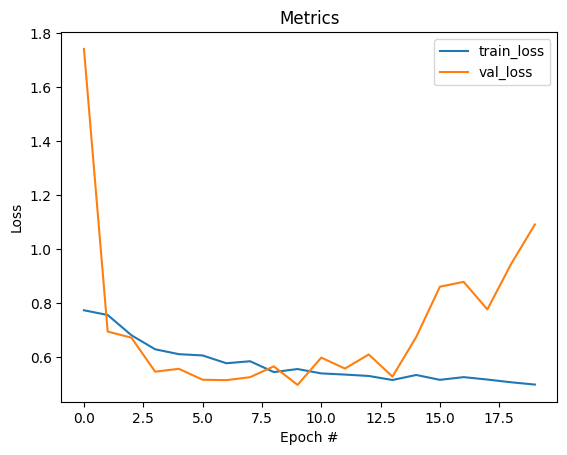

In [ ]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[0]], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[3]], label="val_loss")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

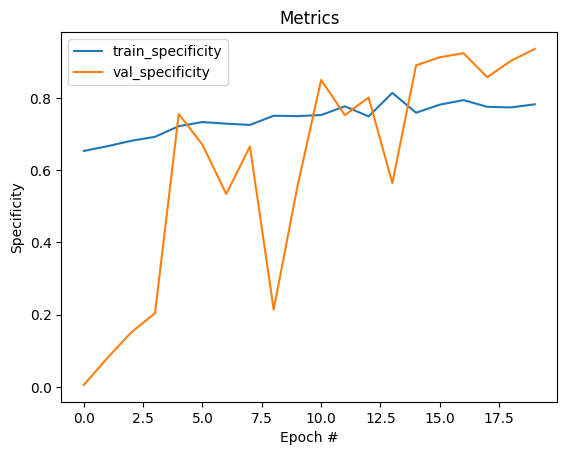

In [ ]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[2]], label="train_specificity")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[5]], label="val_specificity")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Specificity")
plt.legend()

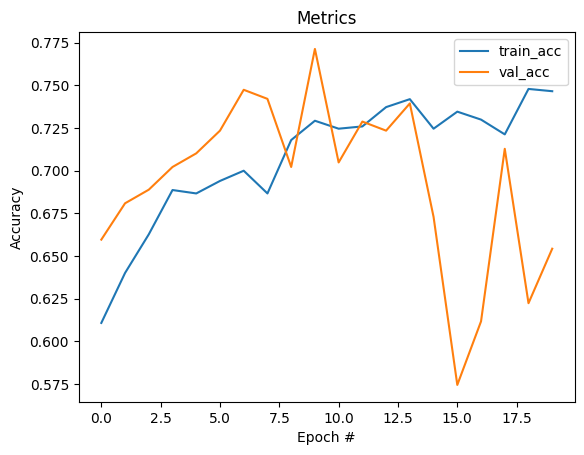

In [ ]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[1]], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[4]], label="val_acc")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

# Keras Tuner - Accuracy

## Create model and look for best hyperparams

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/
def build_model(hp):
  model = Sequential()
  
  hp_units1 = hp.Int('units1', min_value=512, max_value=2048, step=32)
  hp_units2 = hp.Int('units2', min_value=64, max_value=512, step=32)
  # hp_dropout1 = hp.Float('rate1', 0, 0.8, step=0.1)
  # hp_dropout2 = hp.Float('rate2', 0, 0.8, step=0.1)
  hp_dropout1 = hp.Choice('rate1', values=[0.0, 0.25, 0.5, 0.75])
  hp_dropout2 = hp.Choice('rate2', values=[0.0, 0.25, 0.5, 0.75])

  model.add(Dense(units=hp_units1, input_shape=(2881,), activation='relu'))
  model.add(Dropout(rate = hp_dropout1))
  model.add(BatchNormalization())
  
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate = hp_dropout2))
  model.add(BatchNormalization())
  
  # The sigmoid function must be used in the output layer when we build a binary 
  # classifier in which the output is interpreted as a class label depending on 
  # the probability value of input returned by the function.
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

  # The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. 
  # A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.
  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=['accuracy', specificity] # The name string of the metric is always the snake case of the class name
  )

  return model

In [ ]:
K.clear_session()

# initialize tuner to run the model using the Hyperband search algorithm
# https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=es-419
# https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
# Hyperband: Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, 
# train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs. 
# It does this iteratively and finally runs full training and evaluation on the final chosen candidates.
# https://stackoverflow.com/questions/61080146/kerastuner-custom-objective-function
# https://keras.io/guides/keras_tuner/getting_started/

tuner = kt.Hyperband(
    hypermodel = build_model,
    # objective=kt.Objective("val_specificity", direction="max"),
    objective= "val_accuracy",  # The name string of the objective is always in the format of f"val_{metric_name_string}"
    max_epochs=150, # Affects total number of trials
    overwrite = True,
    seed=42)

early_stop = EarlyStopping(monitor='val_loss', patience=10)
class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_s))

tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1, class_weight=class_weights)

Trial 254 Complete [00h 00m 10s]
val_accuracy: 0.728723406791687

Best val_accuracy So Far: 0.8244680762290955
Total elapsed time: 00h 30m 41s


In [ ]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
units1: 1472
units2: 416
rate1: 0.0
rate2: 0.75
learning_rate: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.8244680762290955


## Train best model and evaluate it

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"The hyperparameter search is complete. \
# The optimal number of units in the first densely-connected layer is {best_hps.get('units1')},\
# \n the optimal dropout rate after the first layer is {best_hps.get('rate1')}\
# \n the optimal number of units in the second densely-connected layer is {best_hps.get('units2')},\
# \n the optimal dropout rate after the second layer is {best_hps.get('rate2')}\
# \n and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}") 

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps)
# model = tuner.get_best_models(1)[0]



In [ ]:
K.clear_session()
print("[INFO] training the best model...")
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
H = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, checkpointer], verbose=1, class_weight=class_weights)  

[INFO] training the best model...
Epoch 1/100
47/47 [==============================] - 3s 18ms/step - loss: 0.7657 - accuracy: 0.5995 - specificity: 0.6116 - val_loss: 0.7428 - val_accuracy: 0.7314 - val_specificity: 0.5672
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.6427 - accuracy: 0.6600 - specificity: 0.6973 - val_loss: 0.5423 - val_accuracy: 0.7527 - val_specificity: 0.5794
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: 0.5915 - accuracy: 0.7066 - specificity: 0.7627 - val_loss: 0.9884 - val_accuracy: 0.5957 - val_specificity: 0.8439
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5479 - accuracy: 0.7365 - specificity: 0.7841 - val_loss: 0.5123 - val_accuracy: 0.7394 - val_specificity: 0.6685
Epoch 5/100
47/47 [==============================] - 1s 14ms/step - loss: 0.5234 - accuracy: 0.7405 - specificity: 0.7643 - val_loss: 0.4707 - val_accuracy: 0.7553 - val_specificity: 0.6124
Epoch 6/100
47/47

[INFO] evaluating best model...
15/15 [==============================] - 0s 2ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70       157
           1       0.86      0.83      0.84       313

    accuracy                           0.80       470
   macro avg       0.77      0.78      0.77       470
weighted avg       0.80      0.80      0.80       470

[[113  44]
 [ 52 261]]


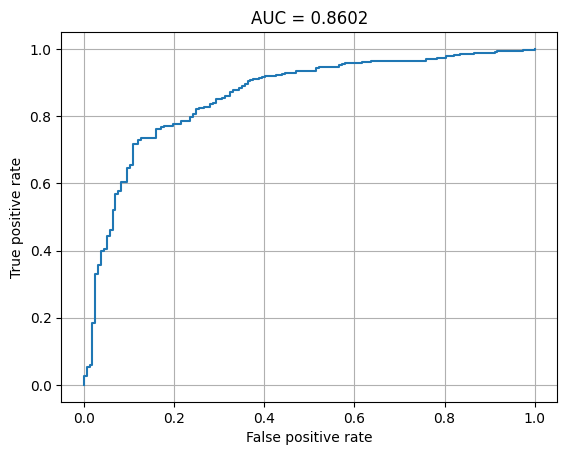

In [ ]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción

model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# acc = (tp + tn)/(tp + tn + fp + fn)
# spe = (tn)/(tn+fp)
# sens = (tp)/(tp+fn)
# print(f"Accuracy: {acc*100:.2f}% \nSpecificity: {spe*100:.2f}% \nSensitivity: {sens*100:.2f}%")

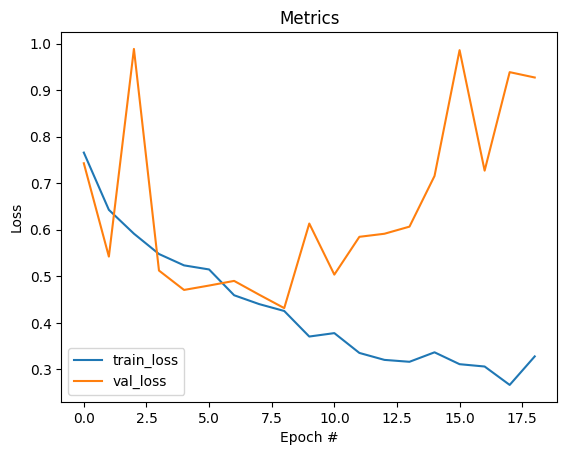

In [ ]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[0]], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[3]], label="val_loss")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

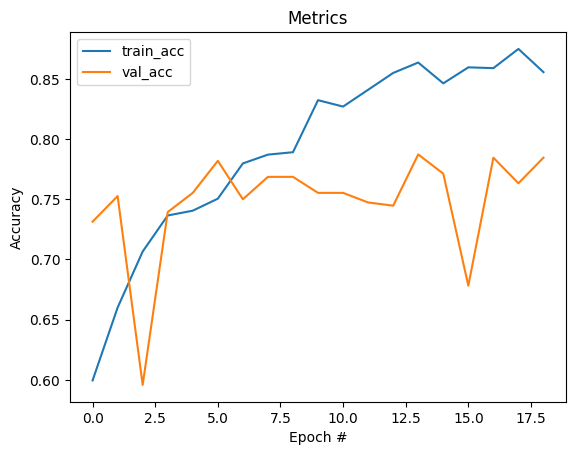

In [ ]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[1]], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[4]], label="val_acc")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

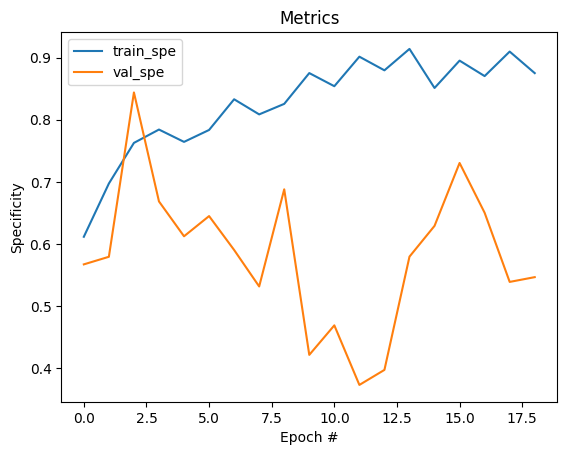

In [ ]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[2]], label="train_spe")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[5]], label="val_spe")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Specificity")
plt.legend()

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1472)              4242304   
                                                                 
 dropout_2 (Dropout)         (None, 1472)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1472)             5888      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 416)               612768    
                                                                 
 dropout_3 (Dropout)         (None, 416)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 416)              1664      
 hNormalization)                                      

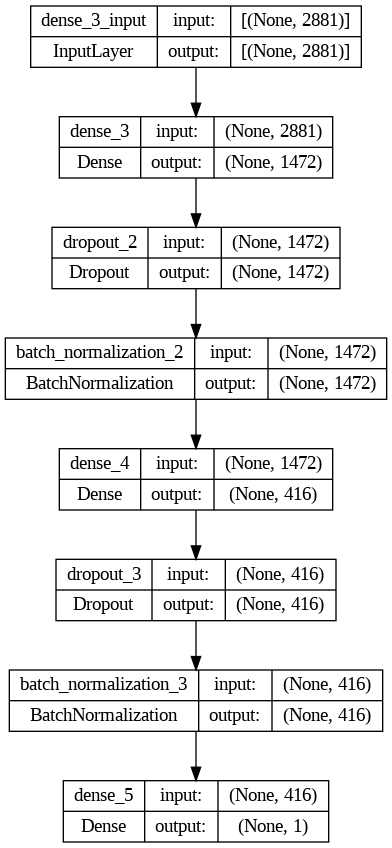

In [ ]:
# display model structure
plot_model(model, 'best_model.png', show_shapes=True)

# Keras Tuner - Specificity

## Create model and look for best hyperparams

In [ ]:
# https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/
def build_model(hp):
  model = Sequential()
  
  hp_units1 = hp.Int('units1', min_value=512, max_value=2048, step=32)
  hp_units2 = hp.Int('units2', min_value=64, max_value=512, step=32)
  # hp_dropout1 = hp.Float('rate1', 0, 0.8, step=0.1)
  # hp_dropout2 = hp.Float('rate2', 0, 0.8, step=0.1)
  hp_dropout1 = hp.Choice('rate1', values=[0.0, 0.25, 0.5, 0.75])
  hp_dropout2 = hp.Choice('rate2', values=[0.0, 0.25, 0.5, 0.75])

  model.add(Dense(units=hp_units1, input_shape=(2881,), activation='relu'))
  model.add(Dropout(rate = hp_dropout1))
  model.add(BatchNormalization())
  
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate = hp_dropout2))
  model.add(BatchNormalization())
  
  # The sigmoid function must be used in the output layer when we build a binary 
  # classifier in which the output is interpreted as a class label depending on 
  # the probability value of input returned by the function.
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. 
  # A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.
  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=['accuracy', specificity] # The name string of the metric is always the snake case of the class name
  )

  return model

In [ ]:
K.clear_session()

# initialize tuner to run the model using the Hyperband search algorithm
# https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=es-419
# https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
# Hyperband: Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, 
# train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs. 
# It does this iteratively and finally runs full training and evaluation on the final chosen candidates.
# https://stackoverflow.com/questions/61080146/kerastuner-custom-objective-function
# https://keras.io/guides/keras_tuner/getting_started/

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective=[kt.Objective("val_specificity", direction="max"), kt.Objective("val_accuracy", direction="max")],
    # objective= "val_accuracy",  # The name string of the objective is always in the format of f"val_{metric_name_string}"
    max_epochs=150, # Affects total number of trials
    overwrite = True,
    seed=42)

early_stop = EarlyStopping(monitor='val_loss', patience=10)
class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_s))

tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stop], verbose=1, class_weight=class_weights)

Trial 254 Complete [00h 00m 11s]
multi_objective: -1.5249359011650085

Best multi_objective So Far: -1.6654606461524963
Total elapsed time: 00h 30m 07s


In [ ]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
units1: 1408
units2: 416
rate1: 0.25
rate2: 0.25
learning_rate: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0230
Score: -1.6654606461524963


## Train best model and evaluate it

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"The hyperparameter search is complete. \
# The optimal number of units in the first densely-connected layer is {best_hps.get('units1')},\
# \n the optimal dropout rate after the first layer is {best_hps.get('rate1')}\
# \n the optimal number of units in the second densely-connected layer is {best_hps.get('units2')},\
# \n the optimal dropout rate after the second layer is {best_hps.get('rate2')}\
# \n and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}") 

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps)
# model = tuner.get_best_models(1)[0]



In [ ]:
K.clear_session()
print("[INFO] training the best model...")
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
H = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, checkpointer], verbose=1, class_weight=class_weights)  

[INFO] training the best model...
Epoch 1/100
47/47 [==============================] - 3s 17ms/step - loss: 0.7260 - accuracy: 0.6361 - specificity: 0.7134 - val_loss: 1.2776 - val_accuracy: 0.6782 - val_specificity: 0.0749
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: 0.5847 - accuracy: 0.7212 - specificity: 0.7519 - val_loss: 0.6321 - val_accuracy: 0.7367 - val_specificity: 0.8312
Epoch 3/100
47/47 [==============================] - 0s 10ms/step - loss: 0.5462 - accuracy: 0.7392 - specificity: 0.7655 - val_loss: 0.5698 - val_accuracy: 0.7340 - val_specificity: 0.7826
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: 0.5146 - accuracy: 0.7505 - specificity: 0.8180 - val_loss: 0.5942 - val_accuracy: 0.7261 - val_specificity: 0.2168
Epoch 5/100
47/47 [==============================] - 0s 10ms/step - loss: 0.4892 - accuracy: 0.7645 - specificity: 0.7849 - val_loss: 0.4801 - val_accuracy: 0.7580 - val_specificity: 0.6109
Epoch 6/100
47/47

[INFO] evaluating best model...
15/15 [==============================] - 0s 4ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       157
           1       0.83      0.86      0.85       313

    accuracy                           0.79       470
   macro avg       0.76      0.75      0.76       470
weighted avg       0.79      0.79      0.79       470

[[101  56]
 [ 43 270]]


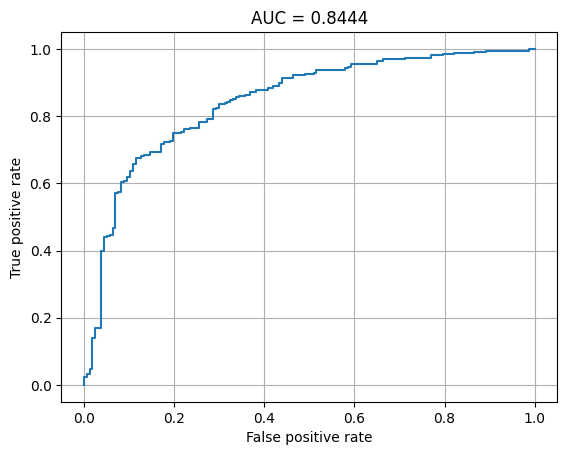

In [ ]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción

model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# acc = (tp + tn)/(tp + tn + fp + fn)
# spe = (tn)/(tn+fp)
# sens = (tp)/(tp+fn)
# print(f"Accuracy: {acc*100:.2f}% \nSpecificity: {spe*100:.2f}% \nSensitivity: {sens*100:.2f}%")

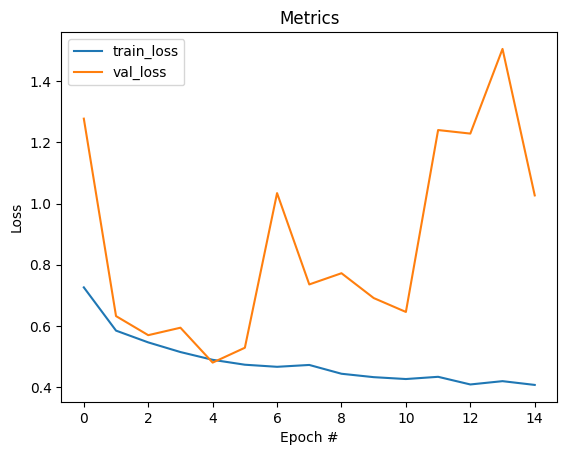

In [ ]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[0]], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[3]], label="val_loss")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

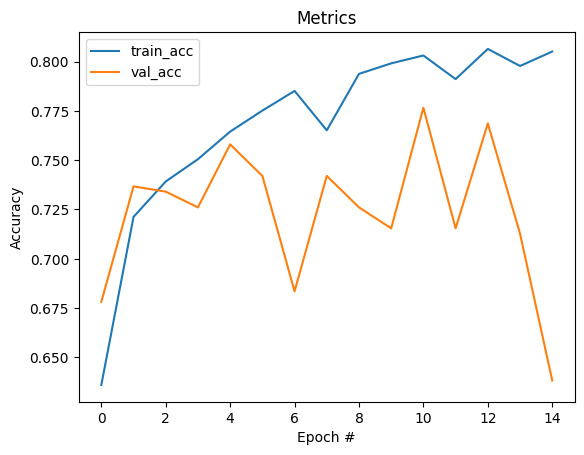

In [ ]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[1]], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[4]], label="val_acc")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

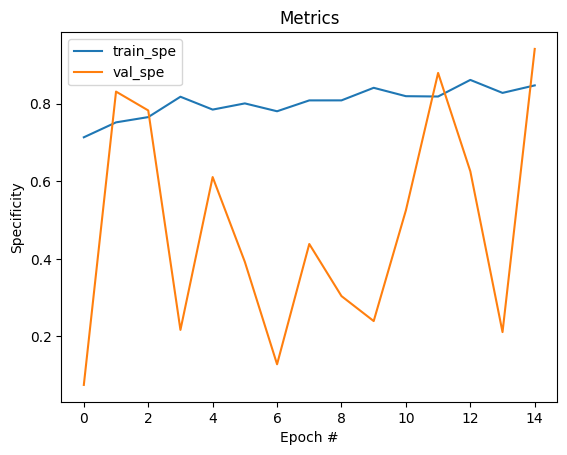

In [ ]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[2]], label="train_spe")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[5]], label="val_spe")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Specificity")
plt.legend()

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1408)              4057856   
                                                                 
 dropout_2 (Dropout)         (None, 1408)              0         
                                                                 
 batch_normalization_2 (Batc  (None, 1408)             5632      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 416)               586144    
                                                                 
 dropout_3 (Dropout)         (None, 416)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 416)              1664      
 hNormalization)                                      

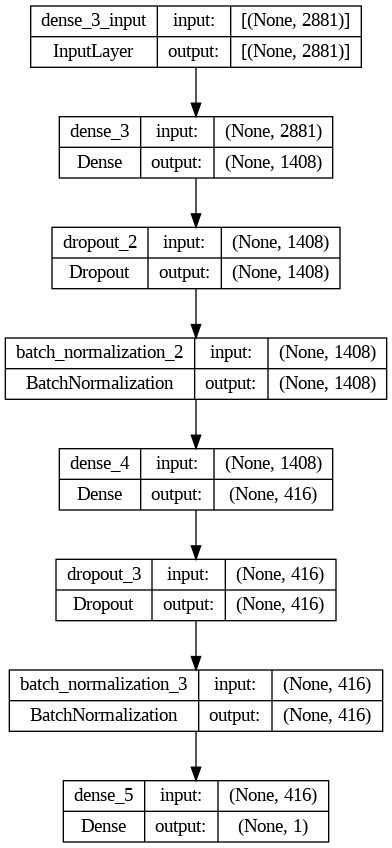

In [ ]:
# display model structure
plot_model(model, 'best_model.png', show_shapes=True)

## Test

In [ ]:
model = Sequential() 
# Input: 2881 neuronas
model.add(Dense(1408, input_shape=(2881,), activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(416, activation="relu"))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# Output: 1 neuron (class Malignant and nonMalignant)
model.add(Dense(1, activation="sigmoid"))

opt = Adam(learning_rate = 0.001, beta_1 = 0.5)

model.compile(optimizer= opt,
              loss='binary_crossentropy',
              metrics = ['accuracy', specificity])

In [ ]:
K.clear_session()

print("[INFO] training the best model...")
# Early Stop
early_stop = EarlyStopping(monitor='val_loss', patience=10)
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_s))

H = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stop, checkpointer], class_weight=class_weights)

[INFO] training the best model...
Epoch 1/100
47/47 [==============================] - 3s 16ms/step - loss: 0.7638 - accuracy: 0.6267 - specificity: 0.6752 - val_loss: 2.3800 - val_accuracy: 0.5160 - val_specificity: 0.6208
Epoch 2/100
47/47 [==============================] - 1s 12ms/step - loss: 0.6529 - accuracy: 0.6880 - specificity: 0.7216 - val_loss: 1.1890 - val_accuracy: 0.6729 - val_specificity: 0.1026
Epoch 3/100
47/47 [==============================] - 1s 11ms/step - loss: 0.5555 - accuracy: 0.7132 - specificity: 0.7404 - val_loss: 0.7771 - val_accuracy: 0.7527 - val_specificity: 0.4898
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: 0.5523 - accuracy: 0.7405 - specificity: 0.7806 - val_loss: 0.9057 - val_accuracy: 0.7261 - val_specificity: 0.4384
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: 0.5221 - accuracy: 0.7525 - specificity: 0.7734 - val_loss: 0.9896 - val_accuracy: 0.7819 - val_specificity: 0.6197
Epoch 6/100
47/47 

[INFO] evaluating best model...
15/15 [==============================] - 0s 3ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.70      0.46      0.56       157
           1       0.77      0.90      0.83       313

    accuracy                           0.76       470
   macro avg       0.74      0.68      0.70       470
weighted avg       0.75      0.76      0.74       470

[[ 73  84]
 [ 31 282]]


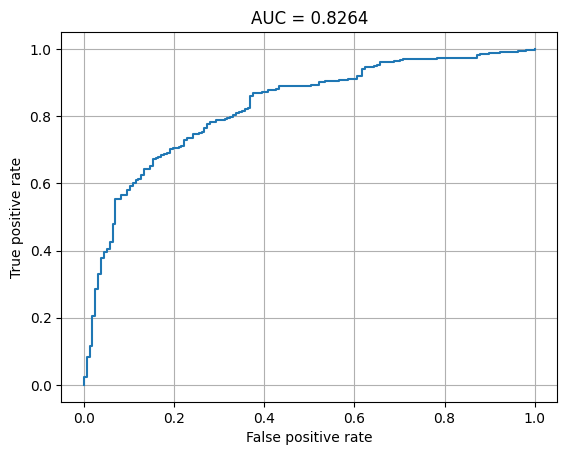

In [ ]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción
model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# Keras Tuner with Data Augmentation: SMOTE

In [17]:
# https://www.mygreatlearning.com/blog/understanding-data-augmentation/
# https://medium.com/analytics-vidhya/smote-nc-in-ml-categorization-models-fo-imbalanced-datasets-8adbdcf08c25
# SMOTE es una técnica de aumento de datos que se utiliza para abordar el problema del desequilibrio de clases en conjuntos de datos. 
# La técnica SMOTE (Synthetic Minority Over-sampling Technique) genera datos sintéticos para la clase minoritaria a partir de los datos existentes, 
# lo que aumenta el número de muestras de la clase minoritaria y ayuda a mejorar el rendimiento del modelo.
# Básicamente, SMOTE toma muestras de la clase minoritaria y crea nuevas muestras sintéticas mediante la interpolación de las características 
# de las muestras existentes. Estas nuevas muestras sintéticas se agregan al conjunto de datos original para equilibrar las clases.

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
sm = SMOTE()
X_train_resampled, y_train_resampled = sm.fit_resample(X_tr, y_tr)

In [18]:
print(X_train.shape, X_tr.shape, X_train_resampled.shape)

(1879, 2881) (1503, 2881) (2080, 2881)


## Create model and look for best hyperparams

In [19]:
# https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/
def build_model(hp):
  model = Sequential()
  
  hp_units1 = hp.Int('units1', min_value=512, max_value=2048, step=32)
  hp_units2 = hp.Int('units2', min_value=64, max_value=512, step=32)
  # hp_dropout1 = hp.Float('rate1', 0, 0.8, step=0.1)
  # hp_dropout2 = hp.Float('rate2', 0, 0.8, step=0.1)
  hp_dropout1 = hp.Choice('rate1', values=[0.0, 0.25, 0.5, 0.75])
  hp_dropout2 = hp.Choice('rate2', values=[0.0, 0.25, 0.5, 0.75])

  model.add(Dense(units=hp_units1, input_shape=(2881,), activation='relu'))
  model.add(Dropout(rate = hp_dropout1))
  model.add(BatchNormalization())
  
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate = hp_dropout2))
  model.add(BatchNormalization())
  
  # The sigmoid function must be used in the output layer when we build a binary 
  # classifier in which the output is interpreted as a class label depending on 
  # the probability value of input returned by the function.
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. 
  # A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.
  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=['accuracy', specificity] # The name string of the metric is always the snake case of the class name
  )

  return model

In [20]:
K.clear_session()

# initialize tuner to run the model using the Hyperband search algorithm
# https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=es-419
# https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
# Hyperband: Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, 
# train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs. 
# It does this iteratively and finally runs full training and evaluation on the final chosen candidates.
# https://stackoverflow.com/questions/61080146/kerastuner-custom-objective-function
# https://keras.io/guides/keras_tuner/getting_started/

tuner = kt.Hyperband(
    hypermodel = build_model,
    # objective=[kt.Objective("val_specificity", direction="max"), kt.Objective("val_accuracy", direction="max")],
    objective= "val_accuracy",  # The name string of the objective is always in the format of f"val_{metric_name_string}"
    max_epochs=150, # Affects total number of trials
    overwrite = True,
    seed=42)

early_stop = EarlyStopping(monitor='val_loss', patience=10)
# class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(class_weights_s))
# , class_weight=class_weights
tuner.search(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=200, callbacks=[early_stop], verbose=1)

Trial 254 Complete [00h 00m 08s]
val_accuracy: 0.7659574747085571

Best val_accuracy So Far: 0.8510638475418091
Total elapsed time: 00h 30m 51s


In [21]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
units1: 896
units2: 288
rate1: 0.0
rate2: 0.75
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0119
Score: 0.8510638475418091


## Train best model and evaluate it

In [22]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"The hyperparameter search is complete. \
# The optimal number of units in the first densely-connected layer is {best_hps.get('units1')},\
# \n the optimal dropout rate after the first layer is {best_hps.get('rate1')}\
# \n the optimal number of units in the second densely-connected layer is {best_hps.get('units2')},\
# \n the optimal dropout rate after the second layer is {best_hps.get('rate2')}\
# \n and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}") 

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps)
# model = tuner.get_best_models(1)[0]



In [23]:
K.clear_session()
print("[INFO] training the best model...")
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
# , class_weight=class_weights
H = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop, checkpointer], verbose=1)  

[INFO] training the best model...
Epoch 1/100
65/65 [==============================] - 2s 11ms/step - loss: 0.7090 - accuracy: 0.6409 - specificity: 0.6630 - val_loss: 1.7272 - val_accuracy: 0.5798 - val_specificity: 0.8638
Epoch 2/100
65/65 [==============================] - 0s 7ms/step - loss: 0.5727 - accuracy: 0.7240 - specificity: 0.7519 - val_loss: 1.1701 - val_accuracy: 0.7340 - val_specificity: 0.8194
Epoch 3/100
65/65 [==============================] - 0s 6ms/step - loss: 0.5305 - accuracy: 0.7428 - specificity: 0.7747 - val_loss: 0.6722 - val_accuracy: 0.8112 - val_specificity: 0.7799
Epoch 4/100
65/65 [==============================] - 0s 7ms/step - loss: 0.4795 - accuracy: 0.7707 - specificity: 0.7867 - val_loss: 0.6394 - val_accuracy: 0.7473 - val_specificity: 0.8506
Epoch 5/100
65/65 [==============================] - 0s 6ms/step - loss: 0.4416 - accuracy: 0.8005 - specificity: 0.8374 - val_loss: 0.7306 - val_accuracy: 0.8005 - val_specificity: 0.7141
Epoch 6/100
65/65 [=

[INFO] evaluating best model...
15/15 [==============================] - 0s 3ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.57      0.90      0.70       157
           1       0.93      0.66      0.77       313

    accuracy                           0.74       470
   macro avg       0.75      0.78      0.74       470
weighted avg       0.81      0.74      0.75       470

[[141  16]
 [105 208]]


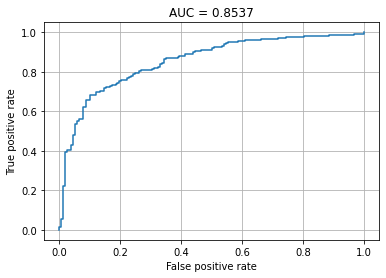

In [24]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción

model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# acc = (tp + tn)/(tp + tn + fp + fn)
# spe = (tn)/(tn+fp)
# sens = (tp)/(tp+fn)
# print(f"Accuracy: {acc*100:.2f}% \nSpecificity: {spe*100:.2f}% \nSensitivity: {sens*100:.2f}%")

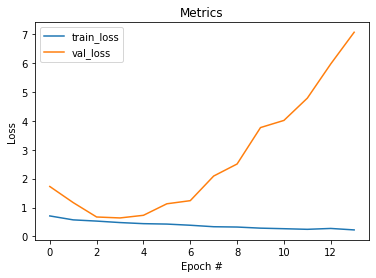

In [25]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[0]], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[3]], label="val_loss")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

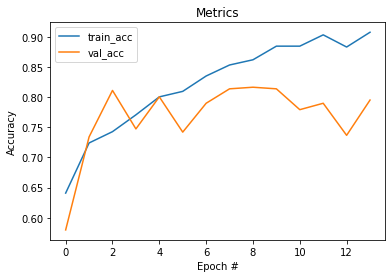

In [26]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[1]], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[4]], label="val_acc")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

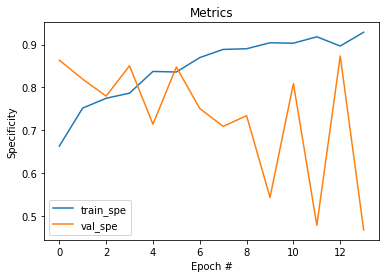

In [27]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[2]], label="train_spe")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[5]], label="val_spe")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Specificity")
plt.legend()

In [28]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 896)               2582272   
                                                                 
 dropout_2 (Dropout)         (None, 896)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 896)              3584      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 288)               258336    
                                                                 
 dropout_3 (Dropout)         (None, 288)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 288)              1152      
 hNormalization)                                      

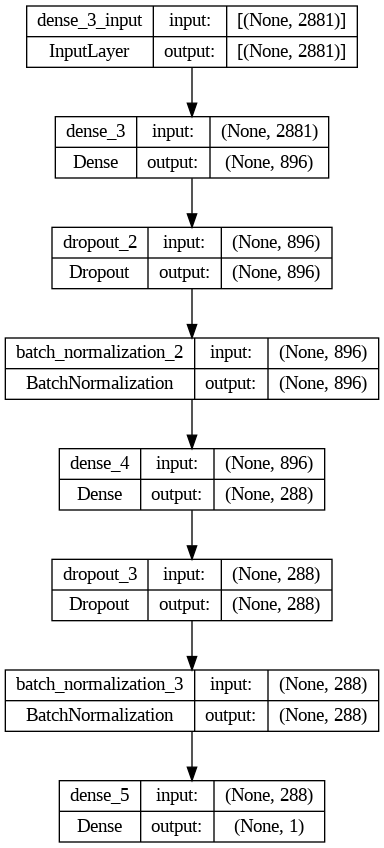

In [29]:
# display model structure
plot_model(model, 'best_model.png', show_shapes=True)

# Keras Tuner with Data Augmentation: SMOTE More data Augmentation

Se puede aumentar el número de datos usando SMOTE varias veces hasta alcanzar la cantidad deseada de datos.

sample_strategy es un argumento que se usa para especificar cómo se debe generar el número de muestras sintéticas en el proceso de sobremuestreo. 
* sample_strategy='auto' genera el número de muestras sintéticas necesarias para igualar el número de muestras de la clase mayoritaria, mientras que 
* sample_strategy=0.5 genera la mitad de la cantidad de muestras de la clase mayoritaria.

In [50]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# sampling_strategy = 'auto'
sampling_strategy = 0.5
sm = SMOTE(sampling_strategy=sampling_strategy)

X_res, y_res = sm.fit_resample(X_tr, y_tr)
X_train_resampled = np.vstack([X_tr, X_res])

# y_train_resampled = np.vstack([y_tr, y_res])
y_train_resampled = pd.concat([y_tr, y_res], axis=0)


In [51]:
# Imprimimos los resultados para verificar que SMOTE-NC haya generado nuevos ejemplos sintéticos
print(X_train.shape, X_tr.shape, X_res.shape, X_train_resampled.shape)

(1879, 2881) (1503, 2881) (1560, 2881) (3063, 2881)


In [52]:
print(y_train.shape, y_tr.shape, y_res.shape, y_train_resampled.shape)

(1879,) (1503,) (1560,) (3063,)


## Create model and look for best hyperparams

In [53]:
# https://www.analyticsvidhya.com/blog/2021/06/tuning-hyperparameters-of-an-artificial-neural-network-leveraging-keras-tuner/
def build_model(hp):
  model = Sequential()
  
  hp_units1 = hp.Int('units1', min_value=512, max_value=2048, step=32)
  hp_units2 = hp.Int('units2', min_value=64, max_value=512, step=32)
  # hp_dropout1 = hp.Float('rate1', 0, 0.8, step=0.1)
  # hp_dropout2 = hp.Float('rate2', 0, 0.8, step=0.1)
  hp_dropout1 = hp.Choice('rate1', values=[0.0, 0.25, 0.5, 0.75])
  hp_dropout2 = hp.Choice('rate2', values=[0.0, 0.25, 0.5, 0.75])

  model.add(Dense(units=hp_units1, input_shape=(2881,), activation='relu'))
  model.add(Dropout(rate = hp_dropout1))
  model.add(BatchNormalization())
  
  model.add(Dense(units=hp_units2, activation='relu'))
  model.add(Dropout(rate = hp_dropout2))
  model.add(BatchNormalization())
  
  # The sigmoid function must be used in the output layer when we build a binary 
  # classifier in which the output is interpreted as a class label depending on 
  # the probability value of input returned by the function.
  model.add(Dense(1, activation='sigmoid'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # The loss function is used to optimize your model. This is the function that will get minimized by the optimizer. 
  # A metric is used to judge the performance of your model. This is only for you to look at and has nothing to do with the optimization process.
  model.compile(
      optimizer=Adam(learning_rate=hp_learning_rate),
      loss='binary_crossentropy',
      metrics=['accuracy', specificity] # The name string of the metric is always the snake case of the class name
  )

  return model

In [54]:
K.clear_session()

# initialize tuner to run the model using the Hyperband search algorithm
# https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=es-419
# https://medium.com/swlh/hyperparameter-tuning-in-keras-tensorflow-2-with-keras-tuner-randomsearch-hyperband-3e212647778f
# Hyperband: Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, 
# train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs. 
# It does this iteratively and finally runs full training and evaluation on the final chosen candidates.
# https://stackoverflow.com/questions/61080146/kerastuner-custom-objective-function
# https://keras.io/guides/keras_tuner/getting_started/

tuner = kt.Hyperband(
    hypermodel = build_model,
    # objective=[kt.Objective("val_specificity", direction="max"), kt.Objective("val_accuracy", direction="max")],
    objective= "val_accuracy",  # The name string of the objective is always in the format of f"val_{metric_name_string}"
    max_epochs=150, # Affects total number of trials
    overwrite = True,
    seed=42)

early_stop = EarlyStopping(monitor='val_loss', patience=10)
# class_weights_s = compute_class_weight(class_weight='balanced', classes = np.unique(y_train), y=y_train)
# class_weights = dict(enumerate(class_weights_s))
# , class_weight=class_weights
tuner.search(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=200, callbacks=[early_stop], verbose=1)

Trial 254 Complete [00h 00m 13s]
val_accuracy: 0.7579787373542786

Best val_accuracy So Far: 0.8510638475418091
Total elapsed time: 00h 38m 16s


In [55]:
tuner.results_summary(1)

Results summary
Results in ./untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
units1: 608
units2: 480
rate1: 0.0
rate2: 0.75
learning_rate: 0.001
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 1
tuner/trial_id: 0160
Score: 0.8510638475418091


## Train best model and evaluate it

In [56]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
# print(f"The hyperparameter search is complete. \
# The optimal number of units in the first densely-connected layer is {best_hps.get('units1')},\
# \n the optimal dropout rate after the first layer is {best_hps.get('rate1')}\
# \n the optimal number of units in the second densely-connected layer is {best_hps.get('units2')},\
# \n the optimal dropout rate after the second layer is {best_hps.get('rate2')}\
# \n and the optimal learning rate for the optimizer is {best_hps.get('learning_rate')}") 

# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
# Build the model with the best hp.
model = tuner.hypermodel.build(best_hps)
# model = tuner.get_best_models(1)[0]



In [63]:
K.clear_session()
print("[INFO] training the best model...")
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=10)
# , class_weight=class_weights
H = model.fit(X_train_resampled, y_train_resampled, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stop, checkpointer], verbose=1)  

[INFO] training the best model...
Epoch 1/100
96/96 [==============================] - 1s 8ms/step - loss: 0.1358 - accuracy: 0.9465 - specificity: 0.9238 - val_loss: 1.3370 - val_accuracy: 0.7739 - val_specificity: 0.4460
Epoch 2/100
96/96 [==============================] - 1s 7ms/step - loss: 0.1627 - accuracy: 0.9383 - specificity: 0.9079 - val_loss: 1.1975 - val_accuracy: 0.7819 - val_specificity: 0.4984
Epoch 3/100
96/96 [==============================] - 1s 6ms/step - loss: 0.1102 - accuracy: 0.9595 - specificity: 0.9497 - val_loss: 1.6406 - val_accuracy: 0.7739 - val_specificity: 0.4165
Epoch 4/100
96/96 [==============================] - 1s 7ms/step - loss: 0.1182 - accuracy: 0.9559 - specificity: 0.9274 - val_loss: 1.8107 - val_accuracy: 0.8191 - val_specificity: 0.6634
Epoch 5/100
96/96 [==============================] - 1s 7ms/step - loss: 0.1191 - accuracy: 0.9533 - specificity: 0.9344 - val_loss: 2.6740 - val_accuracy: 0.7739 - val_specificity: 0.5029
Epoch 6/100
96/96 [==

[INFO] evaluating best model...
15/15 [==============================] - 0s 2ms/step
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.74      0.63      0.68       157
           1       0.83      0.89      0.86       313

    accuracy                           0.80       470
   macro avg       0.79      0.76      0.77       470
weighted avg       0.80      0.80      0.80       470

[[ 99  58]
 [ 34 279]]


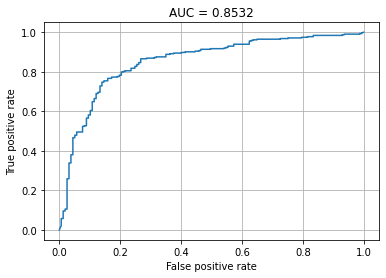

In [64]:
print("[INFO] evaluating best model...")
# Evaluando el modelo de predicción

model.load_weights('weights.hdf5')

predictions = model.predict(X_test)
y_pred = (predictions > 0.5)

print("Tabla de métricas:\n", classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

# Plot ROC curve
auc = roc_auc_score(y_test, predictions)
fpr, tpr, th = roc_curve(y_test, predictions)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid(True)
plt.show()

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# acc = (tp + tn)/(tp + tn + fp + fn)
# spe = (tn)/(tn+fp)
# sens = (tp)/(tp+fn)
# print(f"Accuracy: {acc*100:.2f}% \nSpecificity: {spe*100:.2f}% \nSensitivity: {sens*100:.2f}%")

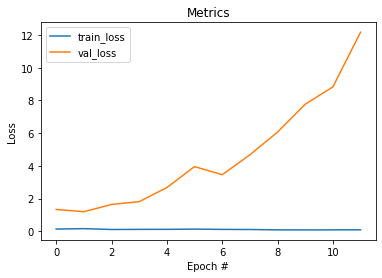

In [65]:
# Muestro gráfica de accuracy y losses
num_epochs = len(H.history["loss"])
plt.figure()
keys_dic = list(H.history.keys())
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[0]], label="train_loss")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[3]], label="val_loss")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()

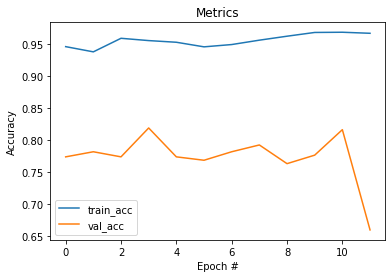

In [66]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[1]], label="train_acc")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[4]], label="val_acc")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()

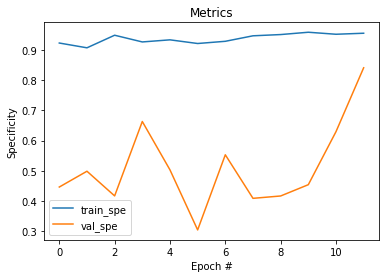

In [67]:
# Muestro gráfica de accuracy y losses
plt.figure()

plt.plot(np.arange(0, num_epochs), H.history[keys_dic[2]], label="train_spe")
plt.plot(np.arange(0, num_epochs), H.history[keys_dic[5]], label="val_spe")
plt.title("Metrics")
plt.xlabel("Epoch #")
plt.ylabel("Specificity")
plt.legend()

In [68]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 608)               1752256   
                                                                 
 dropout_2 (Dropout)         (None, 608)               0         
                                                                 
 batch_normalization_2 (Batc  (None, 608)              2432      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 480)               292320    
                                                                 
 dropout_3 (Dropout)         (None, 480)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 480)              1920      
 hNormalization)                                      

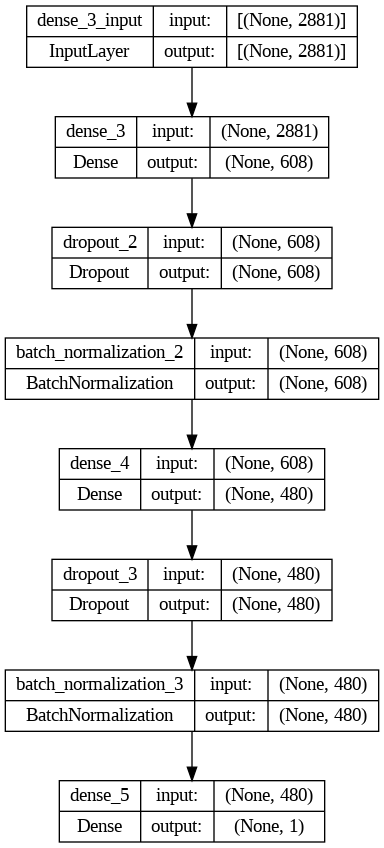

In [69]:
# display model structure
plot_model(model, 'best_model.png', show_shapes=True)